## Config

In [1]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from spacy.tokens import Doc
from spacy.vocab import Vocab
import nltk
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
import random
import itertools
from itertools import chain

from platform import python_version
print("VERSION: ", python_version()) # expect 3.7.0

# dirty spaCy error workaround:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

VERSION:  3.7.0


In [2]:
os_path = '/Users/milk/Desktop/git/'
forms_dir = os_path + 'InformedConsentForms/data/all_forms'

In [3]:
nlp = spacy.load('en')
nlp_larg = spacy.load('en_core_web_lg')

## Semantic Clues

In [4]:
##  taken from: 
# “I found great synonyms for ‘permission’ on the new Thesaurus.com!,”
# www.thesaurus.com. [Online]. Available: https://www.thesaurus.com/browse/permission. 
## [Accessed: 19-Feb-2019].

permission_bases = ["permission", 
                    "authorization", 
                    "authorize",
                    "consent",
                    "assent",
                    "permit",
                    "approve",
                    "grant",
                    "allow",
                    "certify"]

## add synonyms

In [5]:
def addWordNetSynsets(word_list):
    " add synsets to new list "
    updated_list = []
    
    for word in word_list:
        updated_list.append(word)
        synonyms = wordnet.synsets(word, 'v')
        synonyms = set(chain.from_iterable([word.lemma_names() for word in synonyms]))
        
        [updated_list.append(x) for x in synonyms if x not in updated_list]
        
    return updated_list
        
permission_extended = addWordNetSynsets(permission_bases)
print('num elements:', len(permission_extended))
[print(x) for x in permission_extended]

num elements: 51
permission
authorization
authorize
pass
clear
empower
authorise
consent
accept
go_for
assent
accede
acquiesce
permit
allow
countenance
tolerate
let
approve
sanction
okay
O.K.
grant
give
allot
cede
accord
concede
deed_over
award
yield
allow
appropriate
provide
set_aside
allow_for
reserve
take_into_account
give_up
leave
admit
earmark
certify
manifest
endorse
license
indorse
evidence
attest
licence
demonstrate


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## build consent form data structure
get dict and dataframe from each consent form on file

#### todo: get metadata

In [6]:
def getData(directory):
    """ returns a dict with cleaned filenames, full paths,
    and text data in multiple formats from a dictionary
    of .txt files"""
    
    fileDictionary = {}
    fileID = 0
    
    # iterate through directory
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            
            fileID += 1
            filepath = subdir + os.sep + file
            
            if filepath.endswith('.txt'):
                wordList = [] # this will include duplicates and stop words
                cleanedFileName = ''.join(e for e in file if e.isalnum())[:-3] 
                
                # perform string operations on each file
                with open(filepath, 'r') as myfile:
                    data = myfile.read().replace('\n', ' ')       
                
                fileDictionary[fileID] = {}
                fileDictionary[fileID]['name'] = cleanedFileName
                fileDictionary[fileID]['path'] = filepath
                fileDictionary[fileID]['rawText'] = data
    
    return fileDictionary

# run the function and store to variable 
consent_dictionary = getData(forms_dir)

In [7]:
#test print statement
[print(k,v, '\n') for k,v in consent_dictionary[1].items()]

name TAMUHRPPInformedconsent 

path /Users/milk/Desktop/git/InformedConsentForms/data/all_forms/TAMU - HRPP Informed consent.txt 

rawText ﻿NOT INTENDED FOR USE WITHOUT TAMU/BCD IRB APPROVAL  This document is a template for editing to delete highlighted and parenthetical sections.  Project Title:   You are invited to take part in a research study being conducted by Investigator Name, a researcher from Texas A&M University and funded by [name sponsor/funding source]. The information in this form is provided to help you decide whether or not to take part. If you decide to take part in the study, you will be asked to sign this consent form. If you decide you do not want to participate, there will be no penalty to you, and you will not lose any benefits you normally would have.  You may choose to withdraw from the study at any time without penalty.  NOTE:  If you are employed then it is your responsibility to work with your employer regarding work leave for participation in this study if d

[None, None, None]

In [8]:
def toDataFrame(fileDictionary):
    """ return pandas dataframe
    Note: expects input in nested dict format (output from getData)"""
    new_rows = []

    for key, value in fileDictionary.items():
        new_rows.append(value)
         
    df = pd.DataFrame(new_rows)
    return df

df = toDataFrame(consent_dictionary)

df.head(3)

,name,path,rawText
0,TAMUHRPPInformedconsent,/Users/milk/Desktop/git/InformedConsentForms/d...,﻿NOT INTENDED FOR USE WITHOUT TAMU/BCD IRB APP...
1,PotomacPrimaryCarefluconsentform,/Users/milk/Desktop/git/InformedConsentForms/d...,PATIENT CONSENT FORM FOR SEASONAL INFLUENZA VA...
2,OSUScheduledDeliveryConsent,/Users/milk/Desktop/git/InformedConsentForms/d...,SCHEDULED DELIVERY: Today’s Date: Da...


## Random sampling to speed up development
This will be removed when we want to process the whole corpus

In [9]:
# comment out to run on whole corpus
n_samples = 50
df = df.sample(n=n_samples)

## add spacy object to dataframe

#### WARNING: this takes a long time,

In [10]:
def getDocObjects(row, field):
    " return spacy doc object"
#     # small nlp library
#     doc = nlp(str(row[field]).lower())

    # large library
    doc = nlp_larg(str(row[field]).lower())
    return doc

df['docOB'] = df.apply(lambda row:getDocObjects(row, 'rawText'),axis=1)

In [11]:
df['docOB'].head()

628    (﻿,  , emory, university, and, st, ., joseph, ...
227    (﻿biomedical, consent, /, hipaa, form, ,, vers...
179    (informed, consent, for, genetic, testing, *, ...
574    (﻿animas, surgical, hospital, consent, for, in...
268    (1, ., authorization-, i, hereby, authorize, k...
Name: docOB, dtype: object

## extract sentences

In [12]:
def getSentenceList(row, field):
    " return list of sents from doc object"
    sent_list = []
    
    # must operate on a spaCy doc object 
    for sent in row[field].sents:
#         print(dir(sent))
        sent_list.append(sent)
    
    return sent_list

df['sentList'] = df.apply(lambda row:getSentenceList(row, 'docOB'),axis=1)

In [13]:
def getWordListasString(row):
    """ return a list of words, including duplicates.
    NOTE: light cleaning on ingestion """
    wordList = [] 
    
    for word in row['rawText'].split():
        word = re.sub("[^a-zA-Z]+", " ", word).strip().lower()
        if not word == "":
            wordList.append(word)
            
    return " ".join(wordList)
        
df['cleanedText'] = df.apply(lambda row: getWordListasString(row),axis=1)

df.head(2)

,name,path,rawText,docOB,sentList,cleanedText
628,SJHAICFHIPAATemplate,/Users/milk/Desktop/git/InformedConsentForms/d...,﻿ Emory University and St. Joseph’s Hospital ...,"(﻿, , emory, university, and, st, ., joseph, ...","[(﻿, , emory, university, and, st, .), (josep...",emory university and st joseph s hospital of a...
227,consenthipaaauthorizationform1407777962,/Users/milk/Desktop/git/InformedConsentForms/d...,"﻿Biomedical Consent/HIPAA form, Version Date 5...","(﻿biomedical, consent, /, hipaa, form, ,, vers...","[(﻿biomedical, consent, /, hipaa, form, ,, ver...",biomedical consent hipaa form version date rep...


## preliminary permisison sentence extraction
look for sentences that have a word from the 'clues' list

# NOTE: DO WE WANT SENTENCE PAIRS? THREE SENTENCES?

If sentence contains contains multiple clues, it should only be added once.

In [14]:
def getPossiblePermissions(row, permissions_list):
    """ return list of sentences containing the 
    permissions words """
    
    sent_list = []
    
    for sent in row['sentList']:
        [sent_list.append(sent) for clue in\
             permission_extended if sent.text.__contains__(clue)]
                
    return sent_list

# here we only convert the first 10 rows to save time
df['permissionsStatements'] = df.apply(lambda row:getPossiblePermissions(row, permission_extended),axis=1)

In [15]:
for sent in df['permissionsStatements'][:10]:
    [print('sent:', x.text, '\n') for x in sent[:2]]

sent: joseph’s hospital of atlanta consent to be a research subject and hipaa authorization   

sent: joseph’s hospital of atlanta consent to be a research subject and hipaa authorization   

sent: ﻿biomedical consent/hipaa form, version date 5.16.14 (replaces 7.30.13)   

sent: instructions (should be deleted) instructions are in text boxes and should be deleted.   

sent: informed consent for genetic testing 

sent: *this form does not need to be returned to the medical genomics laboratory if informed consent portion of the test request form has been signed. 

sent: ﻿animas surgical hospital consent for invasive a.i~ non-invasive procedures patient na me, 

sent: rlsks of proposed operation i procedure this authorization is gh·en with the understanding that any procedure or operation in\•olve-s some risks and h~rds. 

sent: authorization- i hereby authorize keith + associates dentistry to insert a dental implant into my alveolar bone. 

sent: authorization- i hereby authorize keith +

In [16]:
def getEstimatedPermissionDesnity(row):
    """ return proportion of sentence total that may
    be statements indicating perissions. Expect much noise. """
     
    return len(row['permissionsStatements'])/len(row['sentList'])
    
df['permissionDensity'] = df.apply(lambda row: getEstimatedPermissionDesnity(row),axis=1)

df.head(2)

,name,path,rawText,docOB,sentList,cleanedText,permissionsStatements,permissionDensity
628,SJHAICFHIPAATemplate,/Users/milk/Desktop/git/InformedConsentForms/d...,﻿ Emory University and St. Joseph’s Hospital ...,"(﻿, , emory, university, and, st, ., joseph, ...","[(﻿, , emory, university, and, st, .), (josep...",emory university and st joseph s hospital of a...,"[(joseph, ’s, hospital, of, atlanta, consent, ...",0.253597
227,consenthipaaauthorizationform1407777962,/Users/milk/Desktop/git/InformedConsentForms/d...,"﻿Biomedical Consent/HIPAA form, Version Date 5...","(﻿biomedical, consent, /, hipaa, form, ,, vers...","[(﻿biomedical, consent, /, hipaa, form, ,, ver...",biomedical consent hipaa form version date rep...,"[(﻿biomedical, consent, /, hipaa, form, ,, ver...",0.169776


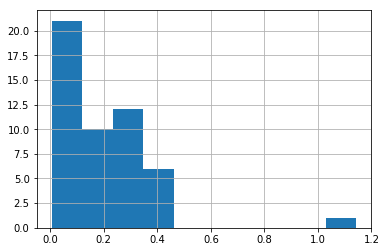

In [17]:
%matplotlib inline
df['permissionDensity'].hist()

## Important
this represents an important break away from the primary dataframe. here i start to work with list structures to create a list of possible permissions that is no longer tied to filenames

In [18]:
all_sents = []

for sentlist in df['sentList'].to_list():
    [all_sents.append(x) for x in sentlist]
    
all_permissions = []

for permlist in df['permissionsStatements'].to_list():
    [all_permissions.append(x) for x in permlist]

In [19]:
print('total rough draft permissions: ', len(all_permissions))
print('unique rough draft permissions: ', len(list(set(all_permissions))))

print('total rough draft sentences: ', len(all_sents))
print('unique rough draft sentences: ', len(list(set(all_sents))))

total rough draft permissions:  1529
unique rough draft permissions:  1207
total rough draft sentences:  11449
unique rough draft sentences:  11449


In [20]:
# remove duplucates
all_permissions = list(set(all_permissions))

## pair-wise similarity between our permission 'guesses' and remaining sentences
this is an important step so that we don't restrict ourselves to permission statements that contain the words we dreampt up

# WARNING: WILL NOT SCALE, need to fix


In [21]:
new_rows = []

for sent in all_sents:
    for perm in all_permissions:
        row = {
            'permission':perm,
            'sentence':sent,
            'similarity':sent.similarity(perm)
        }
        new_rows.append(row)

In [22]:
sf = pd.DataFrame(new_rows)
sf.head()

,permission,sentence,similarity
0,"(3, , annotated, consent, document, for, the,...","(﻿, , emory, university, and, st, .)",0.567261
1,"(an, adverse, event, is, any, health, problem,...","(﻿, , emory, university, and, st, .)",0.472716
2,"(otherwise, ,, just, insert, this, sentence, :...","(﻿, , emory, university, and, st, .)",0.487228
3,"(am, pm, printed, name, of, witness, , signa...","(﻿, , emory, university, and, st, .)",0.493400
4,"(request, and, consent, for, dental, treatment...","(﻿, , emory, university, and, st, .)",0.518084


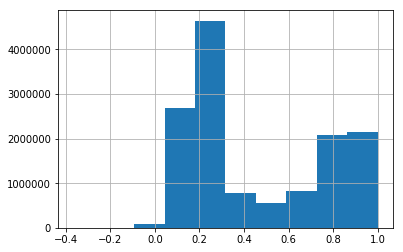

In [23]:
sf['similarity'].hist()

In [24]:
# reduce dataframe, aggregate by mean sim score (weak sents will balance out)
sf = sf.drop(columns=['permission'])
sf = sf.groupby(['sentence'], as_index=False).mean()

sf.head()

,sentence,similarity
0,"(﻿, , emory, university, and, st, .)",0.485246
1,"(scheduled, delivery, :, , today, ’s...",0.625582
2,"(irb, number, :, 2013, -, 0156, irb, approved,...",0.725229
3,"(﻿consent, to, be, part, of, a, research, stud...",0.881840
4,"(college, of, dentistry, consent, for, complet...",0.847961


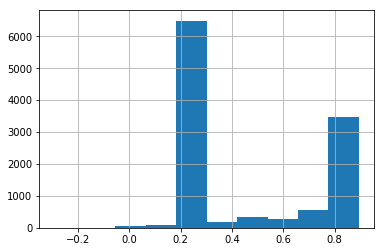

In [25]:
sf['similarity'].hist()

In [26]:
high_sim = sf[sf.similarity > .7]
candidates = high_sim['sentence'].to_list()

In [27]:
print('total rough draft candidates: ', len(candidates))
print('unique rough draft candidates: ', len(list(set(candidates))))

total rough draft candidates:  3908
unique rough draft candidates:  3908


In [28]:
[print('sent: ', x, '\n') for x in candidates[:5]]

sent:  irb number: 2013-0156 irb approved:  04/30/2013 research consent / authorization form  project # 2013-0156  study title: geisinger emerge pgx (pharmacogenomics) project   principal investigator: david j. carey, phd   for additional information, questions or problems contact:   

sent:  ﻿consent to be part of a research study to be conducted at  select appropriate study sites university of texas health science center at san antonio, university health system (uhs), texas biomedical research institute, southwest research institute, christus santa rosa health care  information about this form enrolling children or incompetent adults insert this paragraph only for studies enrolling children or incompetent adults if you are providing consent for someone else, for example your child, your next-of-kin or someone for whom you are the legal guardian or are designated as a surrogate decision maker on a medical power of attorney, please note that in the sections that follow the word "you" r

[None, None, None, None, None]

In [29]:
rough_draft_permissions = all_permissions + candidates

In [30]:
print('total rough draft candidates: ', len(rough_draft_permissions))
print('unique rough draft candidates: ', len(list(set(rough_draft_permissions))))

total rough draft candidates:  5115
unique rough draft candidates:  3990


In [31]:
rough_draft_permissions = list(set(rough_draft_permissions))

## print statements to file

In [32]:
# import csv
# import datetime
# today = str(datetime.date.today())

# file_path = 'statements-'+today+'.csv'
# print(file_path)

# with open(file_path, 'a') as outcsv:   
#     #configure writer to write standard csv file
#     writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
#     writer.writerow(['raw_text', 'clean_text'])
#     for perm in rough_draft_permissions:
#         #Write item to outcsv
#         raw_text = perm.text
#         clean_text = re.sub('\s+', ' ', re.sub('\W+',' ',\
#                                re.sub('[^A-Za-z0-9]+',' ', \
#                                       re.sub(r'\d+', " ", raw_text)))).strip()
#         writer.writerow([raw_text, clean_text])

# Annotations?

This is the point where injecting further information via annotations may be a good idea. This then would require in import of another local file and a small methods section.

## matrix representations

a few different matrix representations of the permissions sentence

In [33]:
def cleanPermissions(rough_draft_permissions):
    "string cleaning on permissions for td-idf ingestion"
    corpus = []
    
    
    for permission in rough_draft_permissions:
        cleanSentence = []
        for word in permission.text.split():
            word = re.sub("[^a-zA-Z]+", " ", word).strip().lower()
            if not word == "":
                cleanSentence.append(word)
        corpus.append(" ".join(cleanSentence))
    return corpus
            
corpus = cleanPermissions(rough_draft_permissions)

[print(x, '\n') for x in corpus[:10]]

difficulties and problems with wearing dentures the difficulties and problems associated with wearing dentures have been presented to me along with my treatment plan 

confidentiality how will your records be kept confidential 

all injections can cause pain in the muscle redness or swelling 

they will follow how the study is done and they will be reviewing your information for this purpose 

natural self induction at home can often take greater than hours to establish active labor 

gene transfer if your protocol uses mri insert the following mri paragraphs as applicable 

there are no study visits or blood draws involved in this study 

in addition the majority of women who were gbs positive did not receive antibiotic prophylaxis therefore this study does not provide guidance 

child s signature or initials date principal investigator or person obtaining assent consent 

for example over time stored samples may be used up or decrease in quality so we may contact you to ask for more 

[None, None, None, None, None, None, None, None, None, None]

## NOTE: 
`minTermFrequencyThreshold = 0` will result in all possible n_grams and will not scale as input size or ngramSize increases. However, it is the most robust representation of the sentence, and is worth exploring for the time being...

In [34]:
ngramSize = 5
maxTermFrequencyThreshold = .8
minTermFrequencyThreshold = .001

def getTDIDFMatrix(corpus, ngram_range, max_df, min_df):
    """ return td-idf matrix and terms """
    
    tfidf_vectorizer = TfidfVectorizer(use_idf=True, 
                                       ngram_range=(1,ngram_range),
                                       max_df=max_df,min_df=min_df)
    
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
    terms = tfidf_vectorizer.get_feature_names()
    
    return tfidf_matrix, terms

# save to a variable 
tdidf_matrix, tdidf_terms = getTDIDFMatrix(corpus, 
                                           ngramSize, 
                                           maxTermFrequencyThreshold,
                                           minTermFrequencyThreshold)

# # print tests
# print('\nfirst few terms:')
# [print(" ", x) for x in tdidf_terms[:10]]

print('\nNumber of terms:', len(tdidf_terms))


Number of terms: 10207


In [35]:
sdf = pd.SparseDataFrame(tdidf_matrix, columns=tdidf_terms)

# here we add the sentences back in
sdf['sent'] = corpus

sdf.head()

,ability,ability to,able,able to,able to access,able to use,about,about any,about future,about how,...,your study doctor,your time,your tissues,your treatment,your treatment if,your treatment if you,your treatment if you get,your willingness,your willingness to,yourself
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
permission_vectors = []

for perm in rough_draft_permissions:
#     print(perm.to_array([LOWER, POS, ENT_TYPE, IS_ALPHA])) # same features, different rows
#     print(perm.vector) # same shape
#     print(perm.vector_norm) # single value
#     print(perm.get_lca_matrix()) # differnt shapes
    permission_vectors.append(perm.vector)